In [21]:
import re
import os
import pickle
import itertools
import collections
# import ray
# ray.init(ignore_reinit_error=True)

import torch
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report
from parsivar import POSTagger

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
class DT(torch.utils.data.Dataset):
    java_path = "C:\\Program Files\\Common Files\\Oracle\\Java\\javapath"
    tagger = POSTagger(tagging_model="wapiti", jdk_variable_path=java_path)

    def __init__(self, path, t, margin=1, tokens=None):
        self.tokens = tokens if tokens is not None else {} 
        self.tokens_set = set(self.tokens.keys())

        with open(path, 'r', encoding='utf8') as file:
            print('loading data...')
            lines = file.read().split('\n\n')
            lines = [self.split_words(x) for x in lines if len(x) > 0]

            if margin > 0:
                print('removing length outliers...')
                l = [len(x[0]) for x in lines]
                b1p = np.quantile(l, margin/100, interpolation='nearest')
                t1p = np.quantile(l, (100 - margin)/100, interpolation='nearest')
                lines = [x for x in lines if b1p < len(x[0]) < t1p]

            self.lengths = np.array([len(x[0]) for x in lines])
            self.max_length = self.lengths.max()

            print('embedding data...')
            x,y = list(zip(*lines))
            for a,b in zip(x,t):
                assert len(a) == len(b)
            self.X, self.Y = self.pad_all(x, t, y)

    def split_words(self, line):
        tokens = [(re.sub('\sgen_.*', '',  x), 1 if x.endswith('positive') else 0) for x in line.split('\n')]
        return list(zip(*[x for x in tokens if len(x[0]) > 0]))

    def pad_all(self, x, t, y):
        data = np.zeros((len(x), self.max_length)).astype(int)
        labels = np.zeros((len(x), self.max_length))
        for i, (line, pos, label) in enumerate(zip(tqdm(x), t, y)):
            data[i,:len(line)] = self.embed(line, pos)
            labels[i,:len(label)] = np.array(label)
        return data, labels

    def embed(self, tokens, pos):
        t = [self.tokens[x] if x in self.tokens_set else self.append_token(x) for x in [x[0] if x[1] in ['PO'] else x[1]  for x in pos]]
        return np.array(t)

    def append_token(self, token):
        self.tokens[token] = len(self.tokens) + 1
        self.tokens_set.add(token)
        return len(self.tokens)

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, index):    
        return self.lengths[index], self.X[index], self.Y[index]

In [23]:
with open('pos', 'rb') as file:
    t = pickle.load(file)

In [124]:
dataset = DT('./train.data', t)
dataset.tokens

loading data...
removing length outliers...
embedding data...


{'N': 1,
 'DELM': 2,
 'ADJ': 3,
 'با': 4,
 'در': 5,
 'CON': 6,
 'AR': 7,
 'ADV': 8,
 'V_PR': 9,
 '.': 10,
 'از': 11,
 'DET': 12,
 'به': 13,
 'را': 14,
 'برای': 15,
 'V_PA': 16,
 'تا': 17,
 'بدون': 18,
 'PRO': 19,
 'تحت': 20,
 'دربارة': 21,
 'PS': 22,
 'روی': 23,
 'محض': 24,
 'برایمان': 25,
 'برایتان': 26,
 'IF': 27,
 'بر': 28,
 'بین': 29,
 'علی\u200cرغم': 30,
 'پشت': 31,
 'MORP': 32,
 'درباره\u200cاش': 33,
 'برایشان': 34,
 'زیر': 35,
 'درباره': 36,
 'جهت': 37,
 'PP': 38,
 'میان': 39,
 'توسط': 40,
 'راجع\u200cبه': 41,
 'ز': 42,
 'بخاطر': 43,
 'فاقد': 44,
 'جلو': 45,
 'بهانة': 46,
 'FW': 47,
 'جلوی': 48,
 'درکل': 49,
 'علیه': 50,
 'OH': 51,
 'برایش': 52,
 'ازش': 53,
 'روش': 54,
 'برایم': 55,
 'برایت': 56,
 'توی': 57,
 'وارد': 58,
 'طی': 59,
 'رسمی': 60,
 'مابین': 61,
 'کنار': 62,
 'INT': 63,
 'تو': 64,
 'اومدم': 65,
 'سر': 66,
 'رو': 67,
 'رویش': 68,
 'لای': 69,
 'نزدیک': 70,
 'نزد': 71,
 'پیش': 72,
 'ضمن': 73,
 'به\u200cخوبی': 74,
 'برندة': 75,
 'بزدل': 76,
 'جنبة': 77,
 'الی': 78,
 'بع

In [105]:
skip = 2

for i, sentence in enumerate(t):
    if 'DET' in [x[1] for x in sentence]:
        skip -= 1
        if skip < 0:
            break

# " ".join([x[0] for x in t[i]])
t[i]

[('اینکه', 'CON'),
 ('یک', 'N'),
 ('رسانة', 'N'),
 ('عربی', 'N'),
 ('قطری', 'ADJ'),
 ('و', 'CON'),
 ('تاحدی', 'AR'),
 ('اسلامی', 'AR'),
 ('بتواند', 'V_PR'),
 ('تا', 'PO'),
 ('این', 'DET'),
 ('حد', 'N'),
 ('جدی', 'ADJ'),
 ('و', 'CON'),
 ('موفق', 'ADJ'),
 ('عمل', 'N'),
 ('کند', 'V_PR'),
 ('،', 'DELM'),
 ('بدون', 'PO'),
 ('تعارف', 'N'),
 ('مایة', 'N'),
 ('مباهات', 'N'),
 ('بسیار', 'ADJ'),
 ('است', 'V_PR'),
 ('؛', 'DELM'),
 ('اما', 'CON'),
 ('آزادی', 'N'),
 ('و', 'CON'),
 ('استقلال', 'N'),
 ('رسانه\u200cای', 'ADJ'),
 ('در', 'PO'),
 ('دهکدة', 'N'),
 ('جهانی', 'ADJ'),
 ('سیاست\u200cزده', 'ADJ'),
 ('چیزی', 'N'),
 ('است', 'V_PR'),
 ('که', 'CON'),
 ('باور', 'N'),
 ('کردنش', 'N'),
 ('بسیار', 'ADJ'),
 ('مشکل', 'N'),
 ('است', 'V_PR'),
 ('.', '.')]

In [52]:
t[263], ['PO', 'CON', 'DELM']

([('اگر', 'IF'),
  ('آموزش', 'N'),
  ('رسمی', 'MORP'),
  ('در', 'PO'),
  ('چارچوب', 'N'),
  ('محدود', 'ADJ'),
  ('و', 'CON'),
  ('مشخص', 'ADJ'),
  ('خود', 'PRO'),
  ('باقی', 'N'),
  ('بماند', 'V_PR'),
  ('و', 'CON'),
  ('از', 'PO'),
  ('کتاب\u200cهای', 'N'),
  ('مجهز', 'ADJ'),
  ('آموزشگاهی', 'ADJ'),
  ('دارای', 'ADJ'),
  ('مواد', 'N'),
  ('کتابی', 'ADJ'),
  ('و', 'CON'),
  ('مواد', 'N'),
  ('دیداری', 'ADJ'),
  ('و', 'CON'),
  ('شنیداری', 'ADJ'),
  ('کافی', 'ADJ'),
  ('بهره', 'N'),
  ('نجوید', 'V_PR'),
  ('،', 'DELM'),
  ('و', 'CON'),
  ('به', 'PO'),
  ('نیازهای', 'N'),
  ('واقعیت\u200cهای', 'N'),
  ('جامعه', 'N'),
  ('خود', 'PRO'),
  ('نزدیک', 'ADJ'),
  ('نشود', 'V_PR'),
  ('و', 'CON'),
  ('حتی', 'CON'),
  ('از', 'PO'),
  ('آن', 'PRO'),
  ('پیشی', 'N'),
  ('نگیرد', 'V_PR'),
  ('؛', 'DELM'),
  ('در', 'PO'),
  ('عمل', 'N'),
  ('به', 'PO'),
  ('یک', 'N'),
  ('آموزش', 'N'),
  ('یک\u200cسویه', 'N'),
  ('،', 'DELM'),
  ('ناقص', 'ADJ'),
  ('،', 'DELM'),
  ('منجمد', 'ADJ'),
  ('و', 'CON'),
  

In [40]:
java_path = "C:\\Program Files\\Common Files\\Oracle\\Java\\javapath"
tagger = POSTagger(tagging_model="wapiti", jdk_variable_path=java_path)

In [41]:
@ray.remote
def transform(x):
    return tagger.parse(x)

In [43]:
futures = [transform.remote(i) for i in dataset.X]

In [61]:
a = [list(zip(*x))[1] for x in t]

In [5]:
m = {v: k for k, v in dataset.tokens.items()}

In [6]:
a = dataset[0]
tokens = [m[a[1][x]] for x in range(a[0])]
sentence = " ".join(tokens)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class MyModel(torch.nn.Module):

    def __init__(self, alphabet_size, embedding_size, lstm_size, fc_sizes):
        super(MyModel, self).__init__()

        self.alphabet_size = alphabet_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size

        self.drop = torch.nn.Dropout(p=0.1)
        self.emb = torch.nn.Embedding(alphabet_size, embedding_size)

        self.rnn = torch.nn.LSTM(embedding_size, lstm_size, bidirectional=True, batch_first=True)

        fc_layers = []
        for a, b in zip([lstm_size*2] + fc_sizes[:-1], fc_sizes):
            fc_layers.append(torch.nn.Linear(a, b))
            fc_layers.append(torch.nn.BatchNorm1d(b))
            fc_layers.append(torch.nn.ReLU())
            fc_layers.append(torch.nn.Dropout(0.3))

        self.fc = torch.nn.Sequential(*fc_layers)
        self.out = torch.nn.Linear(fc_sizes[-1], 1)

    def forward(self, lengths, x):
        x = self.emb(x)
        x = self.drop(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.rnn(x)
        x = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)[0]
        x2 = torch.zeros((x.shape[0], dataset.max_length, 1)).to(x.device)
        for i, l in enumerate(lengths):
            o = self.out(self.fc(x[i,0:l,:]))
            x2[i,0:l] = o
        return x2

In [9]:
BATCH_SIZE = 64

dataset_size = len(dataset)
test_size = dataset_size * 2 // 10
train_size = dataset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE*3)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param reduction: `none`|`mean`|`sum`
    :param **kwargs
        balance_index: (int) balance class index, should be specific when alpha is float
    """

    def __init__(self, alpha=3, gamma=2, ignore_index=None, reduction='mean',**kwargs):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6 # set '1e-4' when train with FP16
        self.ignore_index = ignore_index
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

        # if self.alpha is None:
        #     self.alpha = torch.ones(2)
        # elif isinstance(self.alpha, (list, np.ndarray)):
        #     self.alpha = np.asarray(self.alpha)
        #     self.alpha = np.reshape(self.alpha, (2))
        #     assert self.alpha.shape[0] == 2, \
        #         'the `alpha` shape is not match the number of class'
        # elif isinstance(self.alpha, (float, int)):
        #     self.alpha = np.asarray([self.alpha, 1.0 - self.alpha], dtype=np.float).view(2)

        # else:
        #     raise TypeError('{} not supported'.format(type(self.alpha)))

    def forward(self, output, target):
        prob = torch.sigmoid(output)
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)

        valid_mask = None
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()

        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()
        if valid_mask is not None:
            pos_mask = pos_mask * valid_mask
            neg_mask = neg_mask * valid_mask

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -torch.sum(pos_weight * torch.log(prob)) / (torch.sum(pos_weight) + 1e-4)
        
        
        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * torch.sum(neg_weight * F.logsigmoid(-output)) / (torch.sum(neg_weight) + 1e-4)
        loss = pos_loss + neg_loss

        return loss

In [11]:
model = MyModel(len(dataset.tokens) + 1, 32, 128, [256, 128, 64])
model.to(device)
print(model)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = BinaryFocalLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

MyModel(
  (drop): Dropout(p=0.1, inplace=False)
  (emb): Embedding(21, 32)
  (rnn): LSTM(32, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
loss_hist = {
    'train': [],
    'val': []
}

In [14]:
for epoch in tqdm(range(3)):

    train_epoch_loss = []
    val_epoch_loss = []

    model.train()

    for lengths, data, labels in tqdm(train_loader, leave=False):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(lengths, data).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_epoch_loss.append(loss.item())
    
    with torch.no_grad():
        model.eval()

        for lengths, data, labels in tqdm(test_loader, leave=False):
            data = data.to(device)
            labels = labels.to(device)
            
            outputs = model(lengths, data).squeeze()
            loss = criterion(outputs, labels)
            
            val_epoch_loss.append(loss.item())

    loss_hist['train'].append(np.mean(train_epoch_loss))
    loss_hist['val'].append(np.mean(val_epoch_loss))

    print("epoch %d | training loss: %.5f | validation loss: %.5f" % (len(loss_hist['train']), loss_hist['train'][-1], loss_hist['val'][-1]))

print('Finished Training')

RuntimeError: CUDA error: unspecified launch failure

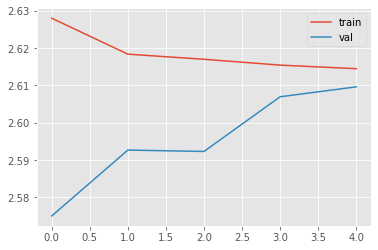

In [15]:
for label, y in loss_hist.items():
    plt.plot(y, label=label)

plt.legend()

In [17]:
device = torch.device('cpu')

In [20]:
real, pred = [], []

with torch.no_grad():
    model.eval()

    for lengths, data, labels in tqdm(test_loader, leave=False):
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = torch.sigmoid(model(lengths, data).squeeze())
        for i, x in enumerate(wl):
            real += [int(x) for x in labels[i,:x.item()].detach().cpu().numpy().tolist()]
            pred += [round(x) for x in outputs[i,:x.item()].detach().cpu().numpy().tolist()]

RuntimeError: CUDA error: unspecified launch failure